In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import random
random.seed(13)
from tqdm.auto import tqdm

import rdkit
print(rdkit.__version__)
from rdkit import Chem
from rdkit.Chem import AllChem 
from rdkit.ML.Cluster import Butina
from rdkit import DataStructs
from rdkit.ML.Scoring.Scoring import CalcBEDROC
import joblib

import sklearn
from sklearn.ensemble import RandomForestClassifier

print(sklearn.__version__)

from imblearn.over_sampling import SMOTE, SMOTENC

/home/sliu/miniconda3/envs/cypscreen/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2021.03.2
1.3.2


In [2]:
from sklearn.metrics import roc_curve, auc
from scipy.interpolate import interp1d
# Function to calculate TPR at specific FPR (e.g., 1%)
def tpr_at_fpr(fpr_array, tpr_array, target_fpr=0.01):
    interp_tpr = interp1d(fpr_array, tpr_array)
    return interp_tpr(target_fpr)

In [3]:
subset1 = pd.read_csv('./datasets/3_train_test_split/chembl_train_ECFP4_rdkit2d.csv')
subset2 = pd.read_csv('./datasets/3_train_test_split/chembl_test_ECFP4_rdkit2d.csv')

In [4]:
print(len(subset1), len(subset2))

1092 273


In [5]:
subset1

,index,preprocessedSmiles,Molecule ChEMBL ID,y_true_label,Molecule,fp,morgan2_b0,morgan2_b1,morgan2_b2,morgan2_b3,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,1972,COc1cccc2c1CC(Cc1ccncc1)C2=O,CHEMBL283782,0,"<img data-content=""rdkit/molecule"" src=""data:i...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1582,Cc1cn2cc(-c3ccc(O)c(O)c3O)nc2s1,CHEMBL2430197,0,"<img data-content=""rdkit/molecule"" src=""data:i...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,2481,CCC#CCOc1cc(Cn2ccnc2)c2oc3ccccc3c(=O)c2c1,CHEMBL4634777,0,"<img data-content=""rdkit/molecule"" src=""data:i...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1807,O=c1ccoc2c(Cn3ccnc3)ccc(Br)c12,CHEMBL161530,0,"<img data-content=""rdkit/molecule"" src=""data:i...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2041,COc1ccc(-c2[nH]c3cc(Cl)ccc3c2Cn2cncn2)cc1,CHEMBL4159159,1,"<img data-content=""rdkit/molecule"" src=""data:i...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1087,2115,CCCC1CCCC2(C)C1=CCC1C3CCC(=O)C3(C)CCC12,CHEMBL1630278,0,"<img data-content=""rdkit/molecule"" src=""data:i...","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1088,2160,COc1cc([N+](=O)[O-])ccc1S(=O)(=O)N1CCCC(Cn2ccn...,CHEMBL3804993,1,"<img data-content=""rdkit/molecule"" src=""data:i...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0,0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1089,2381,COc1ccc2c(c1)CC(Cc1ccncc1)CC2,CHEMBL23365,0,"<img data-content=""rdkit/molecule"" src=""data:i...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1090,1767,N#Cc1cc(Cn2cncn2)cc(-c2ccc(OS(N)(=O)=O)c(Cl)c2)c1,CHEMBL598628,1,"<img data-content=""rdkit/molecule"" src=""data:i...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## prepare similarity based splitting for cross validation

In [6]:
#meeded in cluter with butina function
def tanimoto_distance_matrix(fp_list):
    """
    Calculate distance matrix for fingerprint list.
    Copy pasted form Reference (see top of the notebook).
    """
    dissimilarity_matrix = []
    for i in tqdm(range(1, len(fp_list))):
        # Compare the current fingerprint against all the previous ones in the list
        similarities = DataStructs.BulkTanimotoSimilarity(fp_list[i], fp_list[:i])
        # Since we need a distance matrix, calculate 1-x for every element in similarity matrix
        dissimilarity_matrix.extend([1 - x for x in similarities])
    return dissimilarity_matrix

In [7]:
#cluster with butina

def cluster_fingerprints(fp_list, cutoff=0.7):
    """
    Cluster fingerprints using Butina:
    given the input distance matrix cluster together all the
    molecules with a distance <= cutoff.
    e.g.: if cutoff == 0.3 the molecules with tanimoto >= 0.7
    will be clustered together.

    Returns a list of tuples where each tuple is a cluster
    and each value in the tuple correspond to the fingerprint
    index in the fingerprints list.

    Copy pasted from the Reference (see top of the notebook)
    """
    # Calculate Tanimoto distance matrix
    print("Computing distance matrix . . .")
    distance_matrix = tanimoto_distance_matrix(fp_list)
    # Cluster the data with the implemented Butina algorithm.
    print("Computing clusters . . .")
    clusters = Butina.ClusterData(distance_matrix, len(fp_list), cutoff, isDistData=True)
    clusters = sorted(clusters, key=len, reverse=True) # Sort the list of clusters in descending order.
    print("Clusters computed!")
    return clusters

In [8]:
smiles = subset1['preprocessedSmiles']
# Get only the values from the series.
smiles_array = smiles.values


In [9]:
smiles_array

array(['COc1cccc2c1CC(Cc1ccncc1)C2=O', 'Cc1cn2cc(-c3ccc(O)c(O)c3O)nc2s1',
       'CCC#CCOc1cc(Cn2ccnc2)c2oc3ccccc3c(=O)c2c1', ...,
       'COc1ccc2c(c1)CC(Cc1ccncc1)CC2',
       'N#Cc1cc(Cn2cncn2)cc(-c2ccc(OS(N)(=O)=O)c(Cl)c2)c1',
       'N#Cc1ccc(-c2ccc(OS(N)(=O)=O)c(Cl)c2)cc1Cn1cncn1'], dtype=object)

In [10]:
print("# of unique smiles:", len(smiles_array))
fingerprints_list = []
for smi in tqdm(smiles):
    mol = Chem.MolFromSmiles(smi) # get mol object
    fps = AllChem.GetMorganFingerprintAsBitVect(mol, 2, 2048)
    fingerprints_list.append(fps)


# of unique smiles: 1092


100%|██████████| 1092/1092 [00:00<00:00, 5744.20it/s]


In [11]:
clusters = cluster_fingerprints(fingerprints_list)

Computing distance matrix . . .


100%|██████████| 1091/1091 [00:00<00:00, 10449.39it/s]

Computing clusters . . .
Clusters computed!


In [12]:
len(clusters)

133

In [13]:
# Specify parameters
folds = 5 # number of splits you need

In [14]:
def cross_validation_splits(smiles, clusters, folds):
    """
    Group smiles strings into n = folds datasets.
    """
    # Number of compounds you want in each split.
    # Assume cv split so same number of compounds for each splits.
    splits_size = np.floor(len(smiles)/folds)
    
    random.shuffle(clusters) # shuffle the clusters

    splits = {key: [] for key in range(folds)}
    key = 0
    for clu in tqdm(clusters):
        # Check that the lenght of the split does not exceed the lenght of the split.
        # This ensure that all the splits will have almost the same lenght.
        if len(splits[key]) <= splits_size:
            splits[key] += list(smiles[list(clu)])
        # If not go to the next split.
        else:
            key += 1
            splits[key] += list(smiles[list(clu)])
    return splits

In [15]:
splits = cross_validation_splits(smiles_array, clusters, folds)

100%|██████████| 133/133 [00:00<00:00, 297040.70it/s]


In [16]:
type(splits)

dict

In [17]:
print(type(splits[0]))

<class 'list'>


In [18]:
type(splits[0][1])

str

In [19]:
len(splits)

5

In [20]:
# Print the lenght of each split.
for idx, val in splits.items():
    print(f"len fold {idx} :", len(val))

len fold 0 : 221
len fold 1 : 289
len fold 2 : 226
len fold 3 : 219
len fold 4 : 137


In [21]:
print(splits.items())

dict_items([(0, ['COc1cnc(NS(=O)(=O)c2ccc(N=CCC(=O)c3cc4ccccc4oc3=O)cc2)nc1', 'O=C(CC=Nc1ccc(S(=O)(=O)Nc2ccccn2)cc1)c1ccc2c(c1)Nc1ccccc1S2', 'O=C(CC=Nc1ccc(S(=O)(=O)Nc2cnc3ccccc3n2)cc1)c1ccc2c(c1)Nc1ccccc1S2', 'O=C(CC=Nc1ccc(S(=O)(=O)Nc2ccccn2)cc1)c1cc2ccccc2oc1=O', 'N=C(N)NS(=O)(=O)c1ccc(N=CCC(=O)c2ccc3c(c2)Nc2ccccc2S3)cc1', 'Cc1ccnc(NS(=O)(=O)c2ccc(N=CCC(=O)c3cc4ccccc4oc3=O)cc2)n1', 'O=C(CC=Nc1ccc(S(=O)(=O)Nc2ccnn2-c2ccccc2)cc1)c1cc2ccccc2oc1=O', 'Cc1nn(-c2cncc(C(C)(C)O)c2)c2cccc(F)c12', 'O=[N+]([O-])c1ccc(N(Cc2ccc(C(F)(F)F)cc2)n2cnnc2)cc1Br', 'O=[N+]([O-])c1ccc(N(Cc2cccc(C(F)(F)F)c2)n2cnnc2)cc1Br', 'O=[N+]([O-])c1ccc(Nn2cnnc2)cc1Br', 'COc1ccc(C(O)(c2cccnc2)c2cc3ccc(OC)cc3o2)cc1', 'COc1ccc2nc3cc(Cl)ccc3c(Nc3cccnc3)c2c1', 'COc1ccc2cc(C(O)(c3ccc(F)cc3)c3cccnc3)oc2c1', 'COc1ccc2cc(C(O)(c3ccc(Cl)cc3)c3cccnc3)oc2c1', 'CCC=CCC=CCC=CCC=CCC=CCC=CCCC(=O)O', 'CCCCCC=CCC=CCC=CCC=CCCCC(=O)O', 'CCC=CCC=CCC=CCC=CCC=CCCCC(=O)O', 'CCCCCC=CCC=CCCCCCCCC(=O)O', 'CCCCCCCCC=CCCCCCCCC(=O)O', 'CCC=CCC=CCC=

In [22]:
def map_func(x):
    for k, v in splits.items():
        if x in v:
            return str(k)


# Create a new column in the dataframe and apply the mapping function to the existing_col column
subset1['cluster_id'] = subset1['preprocessedSmiles'].apply(map_func)
subset1

,index,preprocessedSmiles,Molecule ChEMBL ID,y_true_label,Molecule,fp,morgan2_b0,morgan2_b1,morgan2_b2,morgan2_b3,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,cluster_id
0,1972,COc1cccc2c1CC(Cc1ccncc1)C2=O,CHEMBL283782,0,"<img data-content=""rdkit/molecule"" src=""data:i...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
1,1582,Cc1cn2cc(-c3ccc(O)c(O)c3O)nc2s1,CHEMBL2430197,0,"<img data-content=""rdkit/molecule"" src=""data:i...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0,0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2
2,2481,CCC#CCOc1cc(Cn2ccnc2)c2oc3ccccc3c(=O)c2c1,CHEMBL4634777,0,"<img data-content=""rdkit/molecule"" src=""data:i...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
3,1807,O=c1ccoc2c(Cn3ccnc3)ccc(Br)c12,CHEMBL161530,0,"<img data-content=""rdkit/molecule"" src=""data:i...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
4,2041,COc1ccc(-c2[nH]c3cc(Cl)ccc3c2Cn2cncn2)cc1,CHEMBL4159159,1,"<img data-content=""rdkit/molecule"" src=""data:i...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1087,2115,CCCC1CCCC2(C)C1=CCC1C3CCC(=O)C3(C)CCC12,CHEMBL1630278,0,"<img data-content=""rdkit/molecule"" src=""data:i...","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1088,2160,COc1cc([N+](=O)[O-])ccc1S(=O)(=O)N1CCCC(Cn2ccn...,CHEMBL3804993,1,"<img data-content=""rdkit/molecule"" src=""data:i...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0,0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
1089,2381,COc1ccc2c(c1)CC(Cc1ccncc1)CC2,CHEMBL23365,0,"<img data-content=""rdkit/molecule"" src=""data:i...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
1090,1767,N#Cc1cc(Cn2cncn2)cc(-c2ccc(OS(N)(=O)=O)c(Cl)c2)c1,CHEMBL598628,1,"<img data-content=""rdkit/molecule"" src=""data:i...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


## RDKit 2D models

### cross validation

In [23]:
from sklearn.model_selection import GroupKFold
groups = np.array(subset1['cluster_id'])

In [24]:
sm = SMOTE(random_state = 42)

In [25]:
def roc_cv(X, y, max_features): ## with SMOTE for rdkit2d
    cv = GroupKFold(n_splits=5)
    classifier = RandomForestClassifier(n_estimators=1000, max_features=max_features, 
                                        min_samples_split=2, random_state=42)
                                        #max_features and min_samples_split are actually equal to default
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    BEDROC = []

    fig, ax = plt.subplots()
    for i, (train, test) in enumerate(cv.split(X, y, groups=groups)):
        #add SMOTE to each fold
        
        X_train_sm, y_train_sm = sm.fit_resample(X[train],y[train])
        classifier.fit(X_train_sm, y_train_sm)
        y_prob = classifier.predict_proba(X[test])[:, 1]
        fpr, tpr, thresholds = roc_curve(y[test], y_prob)
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
        label='ROC fold %d (AUC = %0.2f)' % (i+1, roc_auc))
        
        score = list(zip(y_prob, y[test]))
        score.sort(key=lambda x: x[0], reverse=True)
        bedroc_score = CalcBEDROC(score, 1, 80.5)
        BEDROC.append(bedroc_score)

   
    print(BEDROC)
    mean_bedroc = np.mean(BEDROC)
    std_bedroc = np.std(BEDROC)
    print("BEDROC: {:.3f} +/- {:.3f}".format(mean_bedroc, std_bedroc))

    ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        title="Receiver operating characteristic example",
    )
    ax.legend(loc="lower right")
    plt.show()
    return mean_bedroc

In [26]:
desc_cols = subset1.iloc[:, 2055:2263] 

In [27]:
desc_cols

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,12.398067,0.021944,12.398067,0.021944,0.843865,253.301,238.181,253.110279,96.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,9.793202,-0.527745,9.793202,0.353597,0.588674,262.290,252.210,262.041213,92.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,13.008467,-0.065904,13.008467,0.065904,0.408911,358.397,340.253,358.131742,134.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,11.845050,-0.045735,11.845050,0.045735,0.731243,305.131,296.059,303.984740,90.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,6.144522,0.627971,6.144522,0.627971,0.608200,338.798,323.678,338.093439,120.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1087,12.489172,0.028132,12.489172,0.028132,0.576856,314.513,280.241,314.260966,128.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1088,13.053017,-3.798223,13.053017,0.017655,0.559425,380.426,360.266,380.115441,140.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1089,5.325522,0.737969,5.325522,0.737969,0.835659,253.345,234.193,253.146664,98.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1090,11.034854,-4.166733,11.034854,0.072043,0.712034,389.824,377.728,389.034938,132.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
def find_best_max_features(X, y, max_features_list):
    
    best_max_features = None
    best_bedroc = -np.inf  # Initialize with a very low value

    for max_features in max_features_list:
        mean_bedroc = roc_cv(X, y, max_features)
        if mean_bedroc > best_bedroc:
            best_bedroc = mean_bedroc
            best_max_features = max_features

    print(f"Best max_features: {best_max_features} with BEDROC: {best_bedroc:.3f}")
    return best_max_features, best_bedroc

In [29]:
X = np.array(desc_cols)
y = np.array(subset1.y_true_label)

In [30]:
max_features_list = [None, 'sqrt', 0.2, 0.4, 0.8]

[0.9999566873510628, 0.9970127861442272, 0.999982861350825, 0.9887323489845612, 0.999999993862029]
BEDROC: 0.997 +/- 0.004


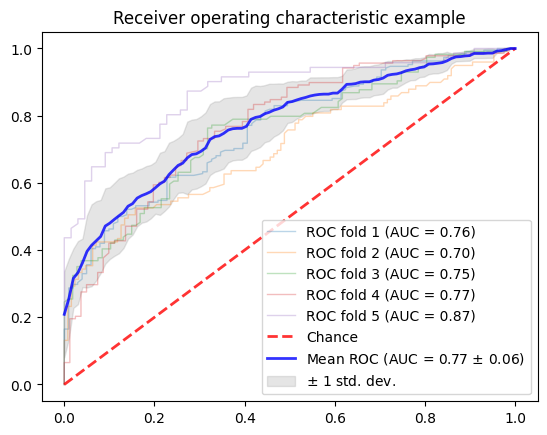

[0.9934536922421192, 0.9940418980149157, 0.9999676952748606, 0.9431870068555048, 0.999999989990905]
BEDROC: 0.986 +/- 0.022


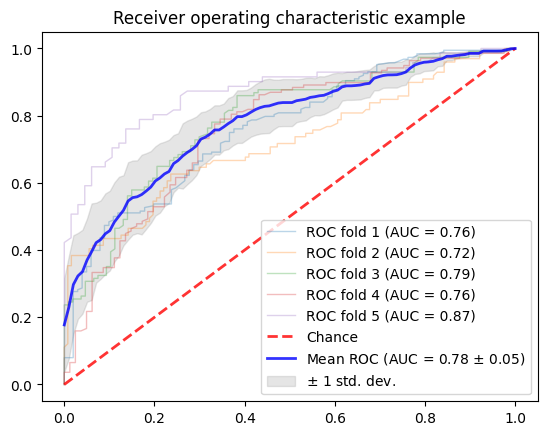

[0.9996204050946388, 0.9940405315558312, 0.9999848639750437, 0.9491096599497046, 0.9999999822610619]
BEDROC: 0.989 +/- 0.020


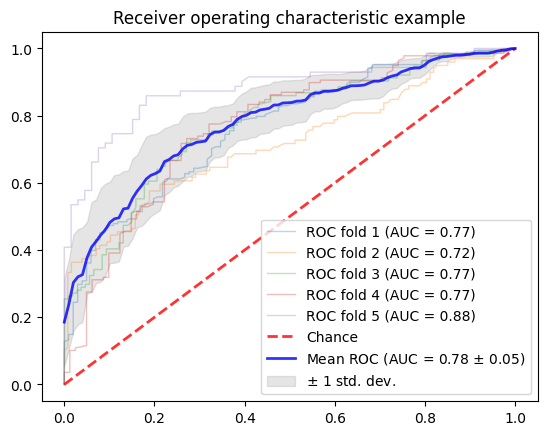

[0.999898201787493, 0.9989938586836823, 0.9999958747812763, 0.9885393279103619, 0.9999999898758276]
BEDROC: 0.997 +/- 0.004


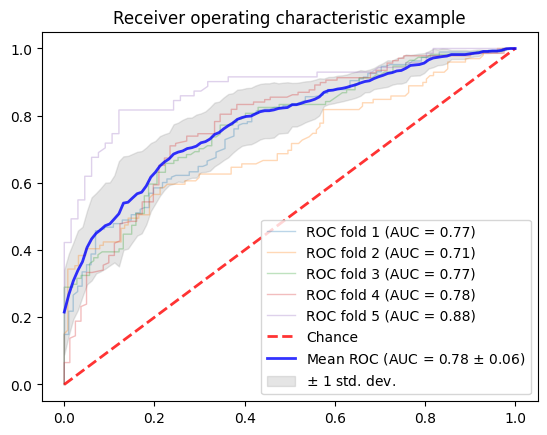

[0.9999427847363811, 0.9989773381846422, 0.9999972599339603, 0.9921840054420629, 0.9999999900030883]
BEDROC: 0.998 +/- 0.003


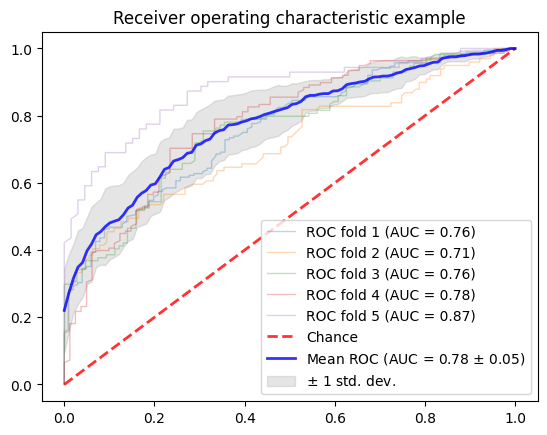

Best max_features: 0.8 with BEDROC: 0.998


In [31]:
best_max_features, best_bedroc = find_best_max_features(X, y, max_features_list)

### combine the folds and train with best hyperparameter

In [32]:
#80% model, with the best hyperparamter
X = np.array(desc_cols)
y = np.array(subset1.y_true_label)
sm = SMOTE(random_state = 42)
X, y = sm.fit_resample(X,y)
model_0 = RandomForestClassifier(n_estimators=1000, max_features=best_max_features, 
                                        min_samples_split=2, random_state=42).fit(X, y)

In [33]:
# test with 20% test set
desc_cols2 = subset2.iloc[:, 2055:2263]
X = np.array(desc_cols2)
y = np.array(subset2.y_true_label)

BEDROC: 0.999


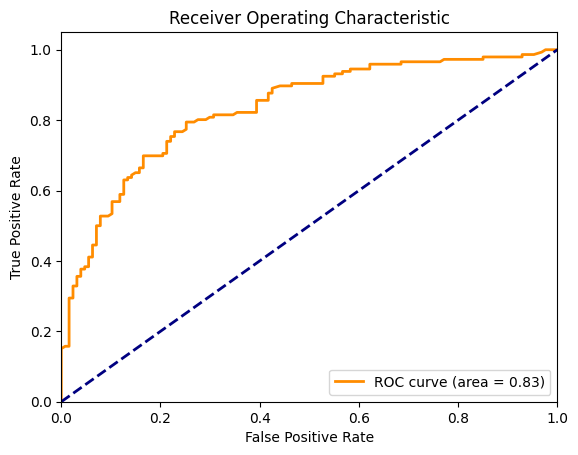

In [34]:
#model_0
# Predict probabilities for the test data
y_scores = model_0.predict_proba(X)[:, 1]

# Compute ROC metrics
fpr, tpr, thresholds = roc_curve(y, y_scores)

# Compute AUC
roc_auc = auc(fpr, tpr)

#bedroc
score = list(zip(y_scores, y))
score.sort(key=lambda x: x[0], reverse=True)
bedroc_score = CalcBEDROC(score, 1, 80.5)
print("BEDROC: {:.3f}".format(bedroc_score))

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()



In [35]:
# combine train and test set and train the final model with full dataset
fullset = pd.concat([subset1, subset2], ignore_index=True)
desc_cols3 = fullset.iloc[:, 2055:2263]
X = np.array(desc_cols3)
y = np.array(fullset.y_true_label)

sm = SMOTE(random_state = 42)
X, y = sm.fit_resample(X,y)

In [36]:
combined_model = RandomForestClassifier(n_estimators=1000, max_features=best_max_features, 
                                        min_samples_split=2, random_state=42).fit(X, y)
joblib.dump(combined_model, f'./trained_models/chembl_rdkit2D_smote_fullset.joblib')

['./trained_models/chembl_rdkit2D_smote_fullset.joblib']

## ECFP4 models

### cross validation

In [37]:
sm = SMOTENC(categorical_features=[0,1], random_state = 42)

In [38]:
def roc_cv_NC(X, y, max_features): ## with SMOTENC for ecfp4
    cv = GroupKFold(n_splits=5)
    classifier = RandomForestClassifier(n_estimators=1000, max_features=max_features, 
                                        min_samples_split=2, random_state=42)
                                        #max_features and min_samples_split are actually equal to default
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    BEDROC = []

    fig, ax = plt.subplots()
    for i, (train, test) in enumerate(cv.split(X, y, groups=groups)):
        #add SMOTE to each fold
    
        X_train_sm, y_train_sm = sm.fit_resample(X[train],y[train])
        classifier.fit(X_train_sm, y_train_sm)
        y_prob = classifier.predict_proba(X[test])[:, 1]
        fpr, tpr, thresholds = roc_curve(y[test], y_prob)
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
        label='ROC fold %d (AUC = %0.2f)' % (i+1, roc_auc))
        
        score = list(zip(y_prob, y[test]))
        score.sort(key=lambda x: x[0], reverse=True)
        bedroc_score = CalcBEDROC(score, 1, 80.5)
        BEDROC.append(bedroc_score)

   
    print(BEDROC)
    mean_bedroc = np.mean(BEDROC)
    std_bedroc = np.std(BEDROC)
    print("BEDROC: {:.3f} +/- {:.3f}".format(mean_bedroc, std_bedroc))

    ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        title="Receiver operating characteristic example",
    )
    ax.legend(loc="lower right")
    plt.show()
    return mean_bedroc

In [39]:
def find_best_max_features(X, y, max_features_list):
    
    best_max_features = None
    best_bedroc = -np.inf  # Initialize with a very low value

    for max_features in max_features_list:
        mean_bedroc = roc_cv_NC(X, y, max_features)
        if mean_bedroc > best_bedroc:
            best_bedroc = mean_bedroc
            best_max_features = max_features

    print(f"Best max_features: {best_max_features} with BEDROC: {best_bedroc:.3f}")
    return best_max_features, best_bedroc

In [40]:
morgan2_cols = ['morgan2_b'+str(i) for i in list(range(2048))]

In [41]:
X = np.array(subset1[morgan2_cols])
y = np.array(subset1.y_true_label)

[0.999988316229265, 0.8970314288825506, 0.9999822999051629, 0.9858873791599888, 0.9998429780445491]
BEDROC: 0.977 +/- 0.040


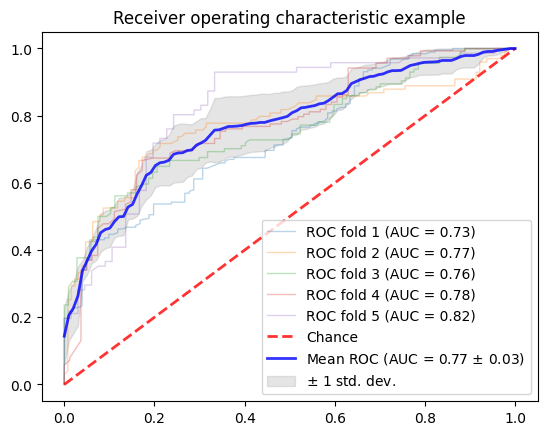

[0.9999999908340121, 0.9999752326050336, 0.9999971995818103, 0.9286898288694486, 0.991485324434596]
BEDROC: 0.984 +/- 0.028


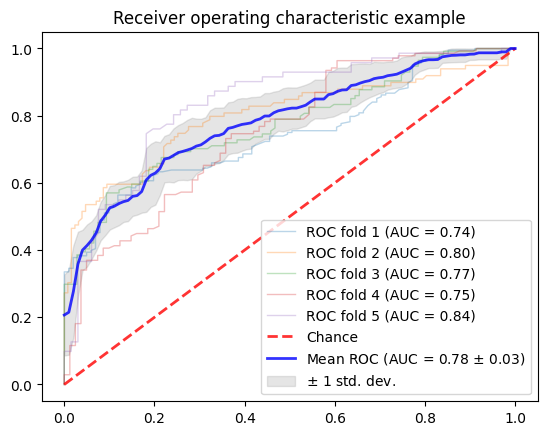

[0.9999999450820699, 0.9999947661616879, 0.9999994187775424, 0.9995124428465295, 0.9965090145471746]
BEDROC: 0.999 +/- 0.001


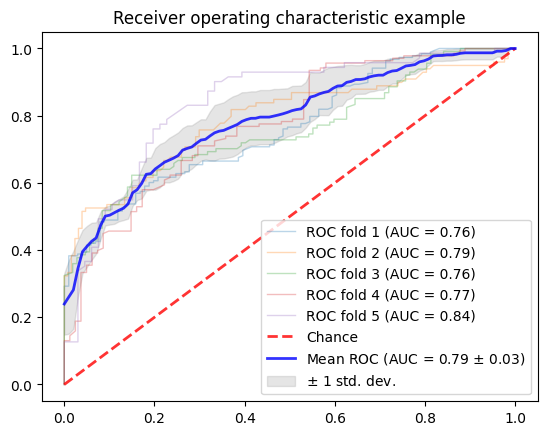

[0.9999996143316481, 0.9998713681879563, 0.9999996929922086, 0.9995761048317238, 0.9965078251276321]
BEDROC: 0.999 +/- 0.001


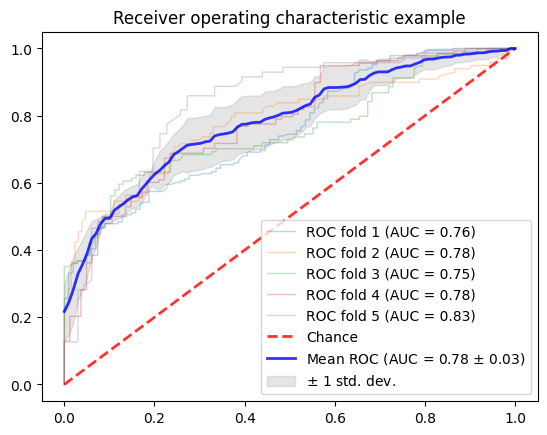

[0.9999890664571179, 0.9826267713289718, 0.9999969119716083, 0.9960624039544187, 0.9996626036765273]
BEDROC: 0.996 +/- 0.007


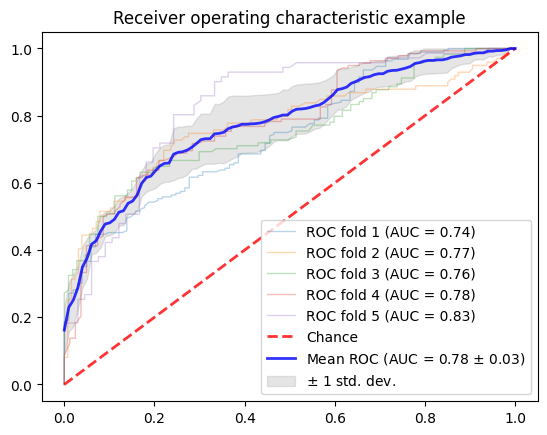

Best max_features: 0.2 with BEDROC: 0.999


In [42]:
best_max_features, best_bedroc = find_best_max_features(np.array(X),np.array(y), max_features_list)

### combine the folds and train with best hyperparameter

In [43]:
#80% model, with best hyperparamter
X = subset1[morgan2_cols]
y = subset1.y_true_label
sm = SMOTENC(categorical_features=[0,1],random_state = 42) 
X, y = sm.fit_resample(X,y)
model_1 = RandomForestClassifier(n_estimators=1000, max_features=best_max_features, 
                                        min_samples_split=2, random_state=42).fit(X,y)

In [44]:
#test with 20% test set
X = np.array(subset2[morgan2_cols])
y = subset2.y_true_label

/home/sliu/miniconda3/envs/cypscreen/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[(1.0, 1), (1.0, 1), (1.0, 1), (0.999, 1), (0.999, 1), (0.997, 1), (0.997, 1), (0.997, 1), (0.997, 1), (0.997, 1), (0.997, 1), (0.996, 1), (0.996, 1), (0.993, 1), (0.993, 1), (0.993, 1), (0.993, 1), (0.992, 1), (0.992, 1), (0.992, 1), (0.992, 1), (0.991, 1), (0.991, 1), (0.991, 1), (0.991, 1), (0.989, 1), (0.989, 1), (0.987, 1), (0.987, 1), (0.985, 1), (0.982, 1), (0.979, 1), (0.978, 0), (0.976, 1), (0.973, 1), (0.973, 1), (0.971, 1), (0.969, 1), (0.965, 1), (0.964, 1), (0.963, 1), (0.961, 1), (0.958, 1), (0.956, 1), (0.954, 1), (0.951, 1), (0.95, 1), (0.95, 1), (0.949, 1), (0.948, 1), (0.941, 0), (0.938, 1), (0.937, 1), (0.937, 1), (0.936, 1), (0.934, 1), (0.93, 1), (0.93, 1), (0.927, 1), (0.927, 1), (0.925, 1), (0.921, 0), (0.92, 1), (0.917, 1), (0.907, 1), (0.905, 1), (0.903, 1), (0.9, 1), (0.897, 1), (0.897, 1), (0.893, 1), (0.892, 1), (0.891, 1), (0.886, 1), (0.885, 1), (0.867, 1), (0.863, 1), (0.863, 1), (0.85, 1), (0.842, 0), (0.839, 1), (0.831, 1), (0.815, 1), (0.808, 1), (0.80

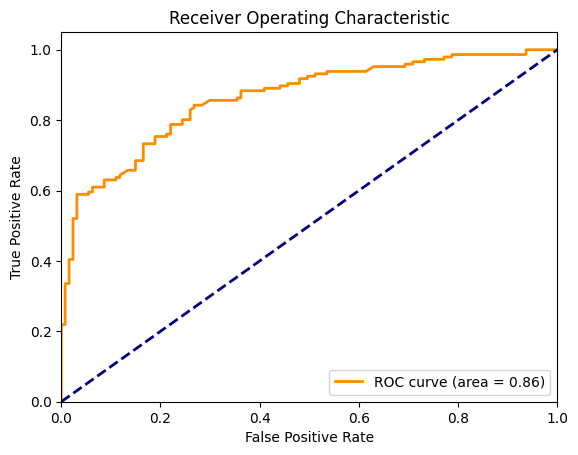

In [45]:
# Predict probabilities for the test data
y_scores = model_1.predict_proba(X)[:, 1]

# Compute ROC metrics
fpr, tpr, thresholds = roc_curve(y, y_scores)

# Compute AUC
roc_auc = auc(fpr, tpr)

#bedroc
score = list(zip(y_scores, y))
score.sort(key=lambda x: x[0], reverse=True)
print(score)
bedroc_score = CalcBEDROC(score, 1, 80.5)
print("BEDROC: {:.3f}".format(bedroc_score))

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [46]:
# combine train and test set and train the final model with full dataset
X = fullset[morgan2_cols]
y = fullset.y_true_label
sm = SMOTENC(categorical_features=[0,1],random_state = 42) 
X, y = sm.fit_resample(X,y)

combined_model = RandomForestClassifier(n_estimators=1000, max_features=best_max_features, 
                                        min_samples_split=2, random_state=42).fit(np.array(X),np.array(y))
joblib.dump(combined_model, f'./trained_models/chembl_morgan2_smote_fullset.joblib')

['./trained_models/chembl_morgan2_smote_fullset.joblib']

## plot for tow models together

In [74]:
# plot the roc curve of the 20% chembl test set on the two models trained with 80% training set
X = np.array(desc_cols2)
y = subset2.y_true_label

# Predict probabilities for the test data with Model 1
y_scores_model_1 = model_0.predict_proba(X)[:, 1]

# compute bedroc
score = list(zip(y_scores_model_1, y))
score.sort(key=lambda x: x[0], reverse=True)
bedroc_score1 = CalcBEDROC(score, 1, 80.5)

# Compute ROC metrics for Model 1
fpr_model_1, tpr_model_1, _ = roc_curve(y, y_scores_model_1)
roc_auc_model_1 = auc(fpr_model_1, tpr_model_1)

X = np.array(subset2[morgan2_cols])
y = subset2.y_true_label


# Predict probabilities for the test data with Model 2
y_scores_model_2 = model_1.predict_proba(X)[:, 1]

# compute bedroc
score = list(zip(y_scores_model_2, y))
score.sort(key=lambda x: x[0], reverse=True)
bedroc_score2 = CalcBEDROC(score, 1, 80.5)

# Compute ROC metrics for Model 2
fpr_model_2, tpr_model_2, _ = roc_curve(y, y_scores_model_2)
roc_auc_model_2 = auc(fpr_model_2, tpr_model_2)


/home/sliu/miniconda3/envs/cypscreen/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


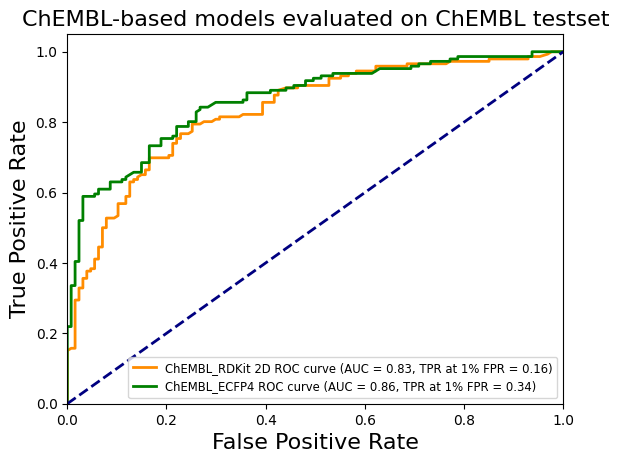

In [75]:
# Calculate TPR at 1% FPR for both models
tpr_at_1_fpr_model_1 = tpr_at_fpr(fpr_model_1, tpr_model_1)
tpr_at_1_fpr_model_2 = tpr_at_fpr(fpr_model_2, tpr_model_2)

# Update the labels to include the early ROC 1% value
label_model_1 = f'ChEMBL_RDKit 2D ROC curve (AUC = {roc_auc_model_1:.2f}, TPR at 1% FPR = {tpr_at_1_fpr_model_1:.2f})'
label_model_2 = f'ChEMBL_ECFP4 ROC curve (AUC = {roc_auc_model_2:.2f}, TPR at 1% FPR = {tpr_at_1_fpr_model_2:.2f})'

# Plot the ROC curves
plt.figure()
plt.plot(fpr_model_1, tpr_model_1, color='darkorange', lw=2, label=label_model_1)
plt.plot(fpr_model_2, tpr_model_2, color='green', lw=2, label=label_model_2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ChEMBL-based models evaluated on ChEMBL testset', fontsize=16)
plt.legend(loc="lower right", fontsize='small')
plt.show()

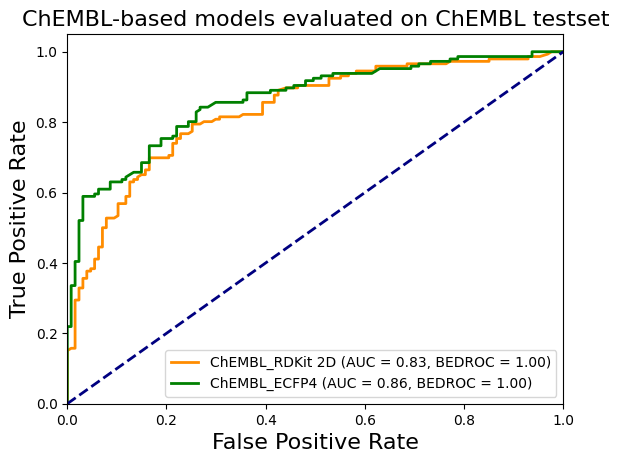

In [76]:
### bedroc version
bedroc_score_model_1 = bedroc_score1
bedroc_score_model_2 = bedroc_score2

plt.figure()
plt.plot(fpr_model_1, tpr_model_1, color='darkorange', lw=2, 
         label=f'ChEMBL_RDKit 2D (AUC = {roc_auc_model_1:.2f}, BEDROC = {bedroc_score_model_1:.2f})')
plt.plot(fpr_model_2, tpr_model_2, color='green', lw=2, 
         label=f'ChEMBL_ECFP4 (AUC = {roc_auc_model_2:.2f}, BEDROC = {bedroc_score_model_2:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ChEMBL-based models evaluated on ChEMBL testset', fontsize=16)
plt.legend(loc="lower right")
plt.show()

## test chembl models with pubchem dataset

In [66]:
# test the full set models with external test set (full set pubchem)
model_2 = joblib.load('./trained_models/chembl_rdkit2D_fullset.joblib')
model_3 = joblib.load('./trained_models/chembl_morgan2_fullset.joblib')

In [67]:
pubchem_testset1 = pd.read_csv('./datasets/3_train_test_split/pubchem_test_ECFP4_rdkit2d.csv')
pubchem_testset2 = pd.read_csv('./datasets/3_train_test_split/pubchem_train_ECFP4_rdkit2d.csv')

In [68]:
pubchem_testset = pd.concat([pubchem_testset1, pubchem_testset2], ignore_index=True)

In [69]:
desc_cols4 = pubchem_testset.iloc[:, 2055:2264]

In [70]:
desc_cols4

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,11.140093,-0.047979,11.140093,0.047979,0.199678,308.506,272.218,308.271530,128.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0
1,12.370387,-1.299841,12.370387,0.013755,0.294720,454.447,432.271,454.171316,172.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,13.824527,-4.442424,13.824527,0.002383,0.714487,469.548,435.276,469.255227,184.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6.134942,0.718433,6.134942,0.718433,0.784348,376.136,355.976,373.999323,100.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,11.440655,-0.521296,11.440655,0.016435,0.528568,309.366,286.182,309.168856,122.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2343,13.398429,-1.502123,13.398429,0.354837,0.512793,417.417,398.265,417.121237,156.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2344,10.003023,-0.662199,10.003023,0.053197,0.744293,277.195,259.051,276.079619,96.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2345,12.447149,-2.218514,12.447149,0.022482,0.462275,325.361,302.177,325.152537,128.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2346,12.624911,-0.016296,12.624911,0.016296,0.665121,250.301,236.189,250.110613,94.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Ploting roc curves

In [71]:
X = np.array(desc_cols4)
y = pubchem_testset.y_true_label

# Predict probabilities for the test data with Model 1
y_scores_model_1 = model_2.predict_proba(X)[:, 1]

# compute bedroc
score = list(zip(y_scores_model_1, y))
score.sort(key=lambda x: x[0], reverse=True)
bedroc_score1 = CalcBEDROC(score, 1, 80.5)


# Compute ROC metrics for Model 1
fpr_model_1, tpr_model_1, _ = roc_curve(y, y_scores_model_1)
roc_auc_model_1 = auc(fpr_model_1, tpr_model_1)

X = np.array(pubchem_testset[morgan2_cols])
y = pubchem_testset.y_true_label


# Predict probabilities for the test data with Model 2
y_scores_model_2 = model_3.predict_proba(X)[:, 1]

# compute bedroc
score = list(zip(y_scores_model_2, y))
score.sort(key=lambda x: x[0], reverse=True)
bedroc_score2 = CalcBEDROC(score, 1, 80.5)

# Compute ROC metrics for Model 2
fpr_model_2, tpr_model_2, _ = roc_curve(y, y_scores_model_2)
roc_auc_model_2 = auc(fpr_model_2, tpr_model_2)

/home/sliu/miniconda3/envs/cypscreen/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


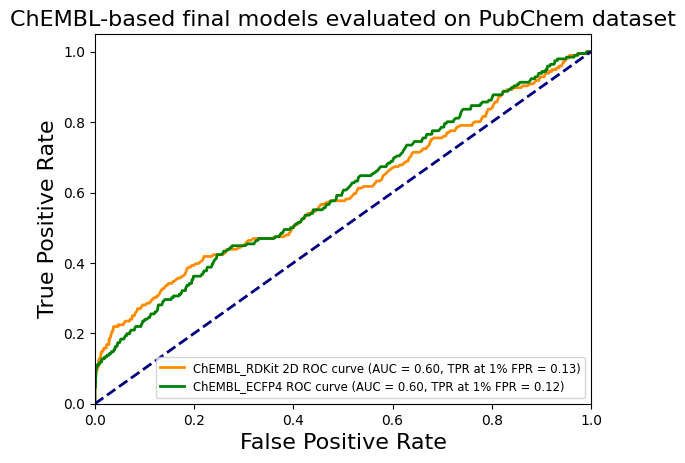

In [72]:
#early ROC version
# Calculate TPR at 1% FPR for both models
tpr_at_1_fpr_model_1 = tpr_at_fpr(fpr_model_1, tpr_model_1)
tpr_at_1_fpr_model_2 = tpr_at_fpr(fpr_model_2, tpr_model_2)
# Update the labels to include the early ROC 1% value
label_model_1 = f'ChEMBL_RDKit 2D ROC curve (AUC = {roc_auc_model_1:.2f}, TPR at 1% FPR = {tpr_at_1_fpr_model_1:.2f})'
label_model_2 = f'ChEMBL_ECFP4 ROC curve (AUC = {roc_auc_model_2:.2f}, TPR at 1% FPR = {tpr_at_1_fpr_model_2:.2f})'

# Plot the ROC curves
plt.figure()
plt.plot(fpr_model_1, tpr_model_1, color='darkorange', lw=2, label=label_model_1)
plt.plot(fpr_model_2, tpr_model_2, color='green', lw=2, label=label_model_2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ChEMBL-based final models evaluated on PubChem dataset', fontsize=16)
plt.legend(loc="lower right", fontsize='small')
plt.show()

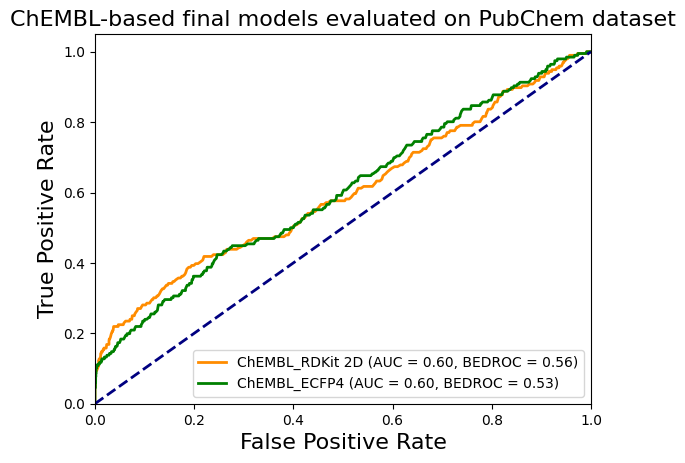

In [73]:
### bedroc version
bedroc_score_model_1 = bedroc_score1
bedroc_score_model_2 = bedroc_score2

plt.figure()
plt.plot(fpr_model_1, tpr_model_1, color='darkorange', lw=2, 
         label=f'ChEMBL_RDKit 2D (AUC = {roc_auc_model_1:.2f}, BEDROC = {bedroc_score_model_1:.2f})')
plt.plot(fpr_model_2, tpr_model_2, color='green', lw=2, 
         label=f'ChEMBL_ECFP4 (AUC = {roc_auc_model_2:.2f}, BEDROC = {bedroc_score_model_2:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ChEMBL-based final models evaluated on PubChem dataset', fontsize=16)
plt.legend(loc="lower right")
plt.show()